In [ ]:
# 라이브러리 실행
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 2014~2018년 전국 부동산 로우데이터
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LH/data/JWS_2014_2018v2.csv',header=None)
# 필요없는열 삭제 ex) 지번코드, 중복되는주소컬럼, 좌표값 등
df = df.drop([0,2,3,4,5,9,11,16],axis=1)
# 컬럼명 지정
df = df.rename(columns={1:'jibun_addr',6:'type_name',7:'rent_area',8:'contract_date',10:'report_date',12:'deposit',13:'rent_price',14:'contract_type',15:'area'})
# 날짜 오류값 수정
df.loc[df.contract_date == 20150032,('contract_date')] = 20150302
df

,jibun_addr,type_name,rent_area,contract_date,report_date,deposit,rent_price,contract_type,area
0,서울특별시 구로구 구로동 798-21,아파트,34.92,20151012,20151012,90000000,0,전세,34.9200
1,서울특별시 구로구 구로동 803-12,다세대,40.17,20150901,20151001,20000000,400000,월세,40.1700
2,서울특별시 구로구 구로동 803-21,다가구,59.39,20150619,20150619,90000000,0,전세,59.3900
3,서울특별시 구로구 구로동 809-15,단독,22.15,20150408,20150709,30000000,300000,월세,22.1500
4,서울특별시 구로구 구로동 809-15,다가구,22.15,20150501,20150520,55000000,0,전세,22.1500
...,...,...,...,...,...,...,...,...,...
6677574,충청남도 천안시 동남구 원성동 581-14,다가구,20.00,20170520,20170523,3000000,270000,월세,20.0000
6677575,충청남도 천안시 동남구 원성동 582-1,아파트,24.58,20170203,20170203,10000000,320000,월세,24.5826
6677576,충청남도 천안시 동남구 원성동 582-1,아파트,24.58,20170105,20170106,20000000,220000,월세,24.5826
6677577,충청남도 천안시 동남구 신부동 321-26,다가구,30.00,20170403,20170403,25000000,200000,월세,30.0000


In [ ]:
# 도시 아파트 전세만 추출하는 함수
def filter(name,city):
  name = str(name) # 주소데이터 한글
  city = str(city) # 변수:도시 영어

  city_jeonse = df[df['jibun_addr'].str.contains(name)] # 한글도시명 도시추출
  city_jeonse = city_jeonse[city_jeonse['type_name'].str.contains('아파트')] # 아파트 추출
  city_jeonse = city_jeonse[city_jeonse['contract_type'].str.contains('전세')] # 전세 추출
  city_jeonse = city_jeonse.reset_index(drop=True, inplace=False) # 인덱스 초기화

  city_count = city_jeonse.groupby('contract_date').count().max(axis=1) # 계약일 기준 그룹화하여 거래건수 추출
  new_df = pd.DataFrame(city_count, columns = ['contract_count']).reset_index() # 데이터프레임형태로 변환 및 contract_count 계약건수 컬럼추가
  new_df['contract_date'] = pd.to_datetime(new_df['contract_date'], format='%Y%m%d') # date형태로 데이터 타입변경
  new_df = new_df.set_index('contract_date') # 계약일을 인덱스로
  new_df = new_df.contract_count.resample('W').sum() # 1주 단위로 계약일 합계
  new_df = pd.DataFrame(new_df) # 데이터프레임 변환
  new_df = new_df.drop(new_df.index[-1]) # 2019년 1월 16일 데이터 삭제
  new_df = new_df.rename(columns = {"contract_count": city})
  return new_df

seoul_2018 = filter('서울특별시','seoul')
# busan = filter('부산광역시','busan')
daejeon_2018 = filter('대전광역시','daejeon')
daegu_2018 = filter('대구광역시','daegu')
# incheon_2018 = filter('인천광역시','incheon')

In [ ]:
# 2019-2020년 서울,대전,대구 전월세 거래 csv 데이터 불러오기
import os
path='/content/drive/MyDrive/Colab Notebooks/LH/data/2019_2020'

file_list = os.listdir(path)
# file_list_xlsx =[file for file in file_list if file.endswith(".xlsx")]
file_list_csv = [file for file in file_list if file.endswith(".csv")]
file_list_csv

import time

lh=pd.DataFrame()

for f in (file_list_csv):
    data=pd.read_csv(path+"/"+f, encoding='euc-kr')
    lh=pd.concat([lh,data])

# Filtering 함수작성
def filter2(name,city):
  name = str(name)
  city = str(city)

  a = lh[lh['지번주소'].str.contains(name) & (lh['월임대료'] == 0)] # 대전아파트 추출, 월임대료 0인 기준으로 전세만 추출
  a = a[a['주택구분명'].str.contains('아파트')] # 아파트만 추출
  a = a.groupby('계약일시').count().max(axis=1) # 계약일 기준으로 그룹화 건수 추출
  a = pd.DataFrame(a).reset_index() # 데이터프레임으로 변환 및 인덱스 리셋
  a = a.rename(columns={'계약일시':'contract_date',0:'contract_count'}) # 컬럼명을 변경
  a['contract_date'] = pd.to_datetime(a['contract_date'], format='%Y%m%d') # date형태로 데이터 타입변경
  a = a.set_index('contract_date') # 계약일을 인덱스로
  a = a.contract_count.resample('W').sum() # 1주 단위로 계약일 합계
  a = pd.DataFrame(a) # 데이터프레임으로 변환
  a = a.rename(columns = {"contract_count": city}) # count 컬럼을 도시명으로
  return a

seoul_2020 = filter2('서울특별시','seoul')
daejeon_2020 = filter2('대전광역시','daejeon')
daegu_2020 = filter2('대구광역시','daegu')

In [ ]:
daegu_2018

,daegu
contract_date,
2014-01-05,159
2014-01-12,300
2014-01-19,318
2014-01-26,302
2014-02-02,163
...,...
2018-12-02,319
2018-12-09,261
2018-12-16,311


In [ ]:
daegu_2020

,daegu
contract_date,
2019-01-06,256
2019-01-13,341
2019-01-20,420
2019-01-27,382
2019-02-03,301
...,...
2020-12-06,381
2020-12-13,319
2020-12-20,317


In [ ]:
# 2014~2020년까지 거래량 데이터 병합!
seoul = pd.concat([seoul_2018, seoul_2020], axis = 0)
daejeon = pd.concat([daejeon_2018, daejeon_2020], axis = 0)
daegu = pd.concat([daegu_2018, daegu_2020], axis = 0)

In [ ]:
# Check for null values
# print('Number of Null Values in Each Column\n')
# for col in city.columns:
#     print(col,' : ', city[col].isnull().sum(),'\n')

# 결측값 확인
print('SEOUL')
print(seoul.isnull().sum(),'\n')
print('DAEJEON')
print(daejeon.isnull().sum(),'\n')
print('DAEGU')
print(daegu.isnull().sum())

SEOUL
seoul    0
dtype: int64 

DAEJEON
daejeon    0
dtype: int64 

DAEGU
daegu    0
dtype: int64


In [ ]:
daegu

,daegu
contract_date,
2014-01-05,159
2014-01-12,300
2014-01-19,318
2014-01-26,302
2014-02-02,163
...,...
2020-12-06,381
2020-12-13,319
2020-12-20,317


In [ ]:
# seoul.to_csv('seoul.csv')

In [ ]:
# 분석용 데이터 불러오기
seoul = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LH/data/seoul.csv')
daejeon = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LH/data/daejeon.csv')
daegu = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LH/data/daegu.csv')
city = pd.concat([seoul, daejeon['daejeon'], daegu['daegu']], axis = 1)
city

,seoul,daejeon,daegu
contract_date,,,
2014-01-05,1215,179,159
2014-01-12,2527,394,300
2014-01-19,2549,346,318
2014-01-26,2335,380,302
2014-02-02,1248,197,163
...,...,...,...
2020-12-06,1812,245,381
2020-12-13,1700,272,319
2020-12-20,1720,276,317


In [ ]:
city.to_csv('df.csv')

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

In [ ]:
# 필요 라이브러리 실행
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf # acf, pacf 
from pandas.plotting import autocorrelation_plot # 자동상관관계플롯
# from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMA

from sklearn import metrics
from sklearn.metrics import mean_squared_error # mse

import plotly.graph_objects as go # plotly graphical object

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot') # 플롯 스타일 지정

<Figure size 432x288 with 0 Axes>

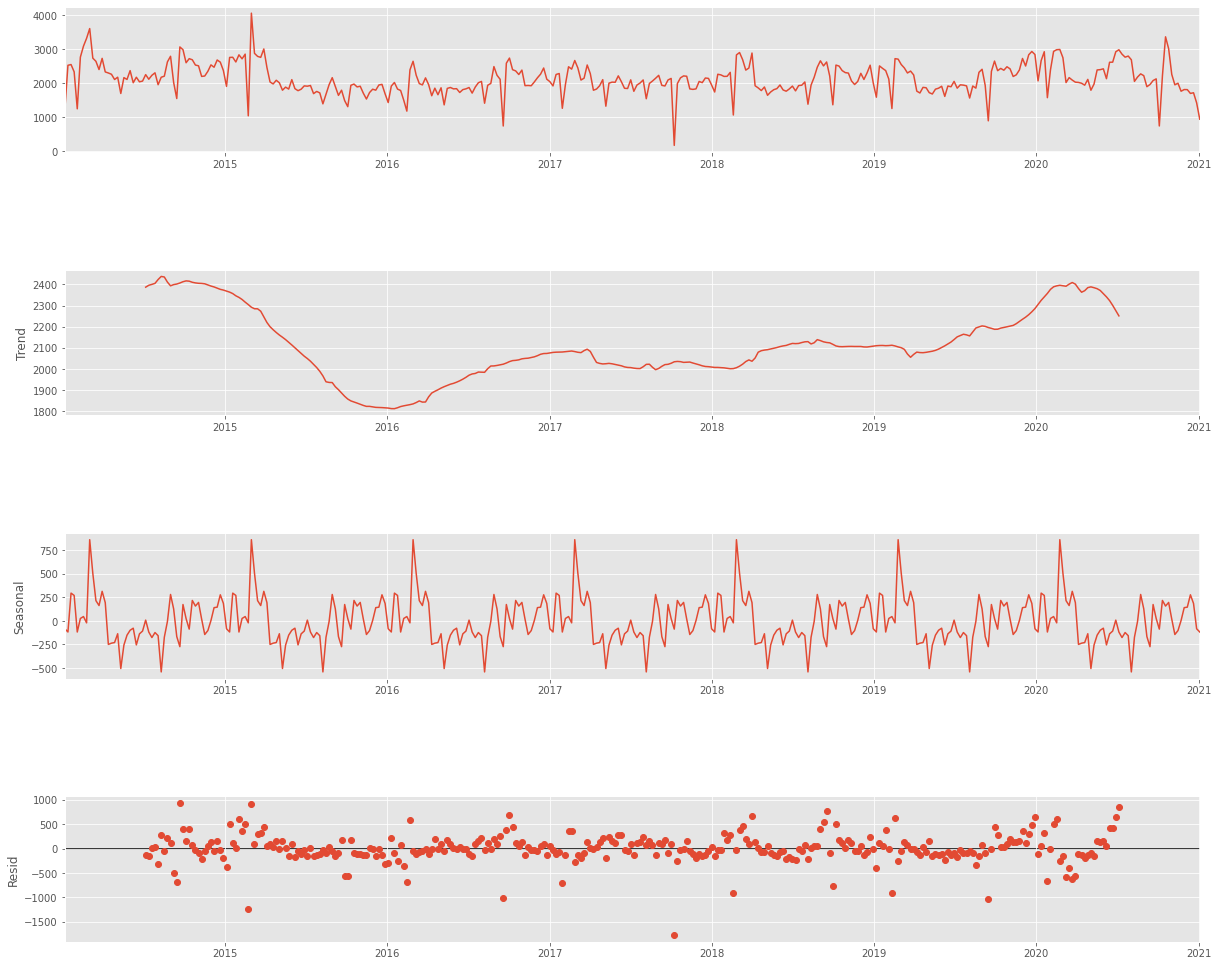

In [ ]:
# 시계열 분해법
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(seoul, model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15,8)
# 데이터가 seasonal 패턴이 보이기 때문에 정상성이 의심됨.

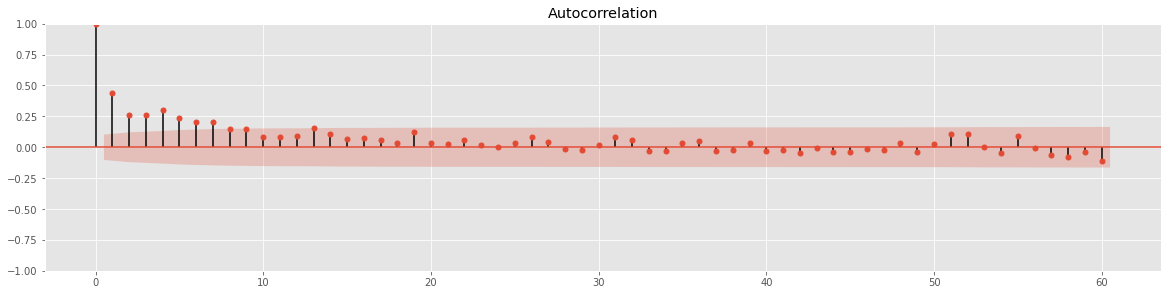

In [ ]:
# ACF 플롯으로 정상성 확인
import statsmodels.api as sm

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seoul,lags=60, ax=ax1) # lag는 1년이 대략 50~60주 이내에 있기때문에 60으로 설정
# 정상성 확인 결과 1 이후에 낮아지고 0에 가까워지므로 정상성을 만족하는것으로 보인다.

In [ ]:
# 단위근 검정 AFD 검정 : 정상성 확인
from statsmodels.tsa.stattools import adfuller

result = adfuller(seoul)
print('ADF Statistic : %f' % result[0])
print('p-value : %f' % result[1])
print('Critical Values : ')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key,value))
# p-value가 0.05 이하이기 때문에 귀무가설 기각, 정상성 만족
# p-value : 유의확률

ADF Statistic : -5.268434
p-value : 0.000006
Critical Values : 
	1%: -3.449
	5%: -2.870
	10%: -2.571


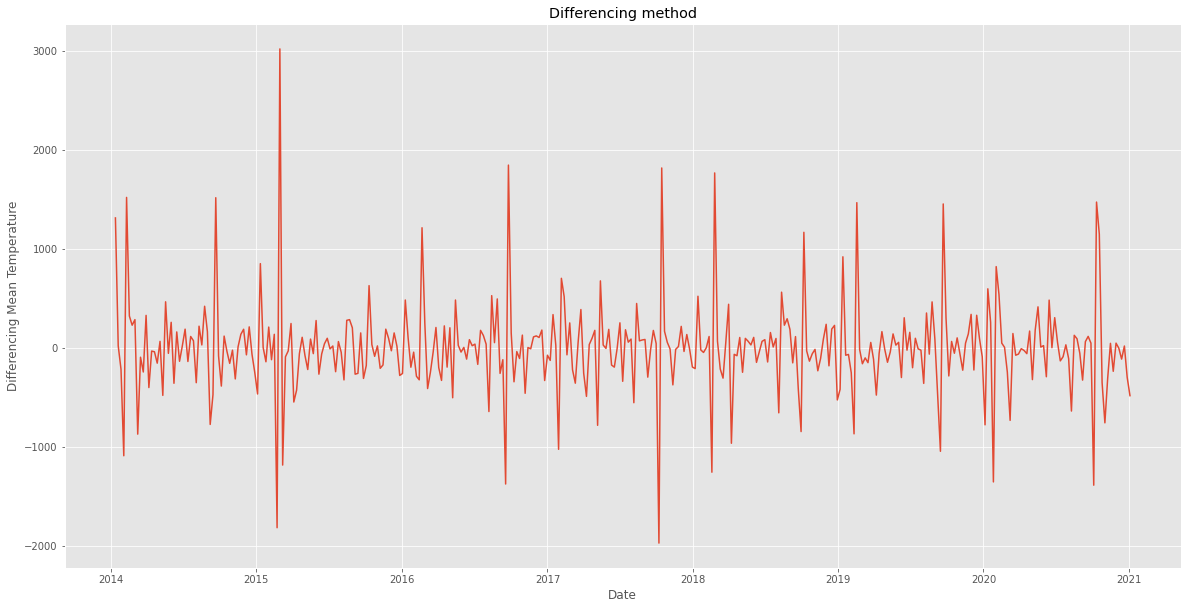

In [ ]:
# 차분
seoul_diff = (seoul - seoul.shift()).dropna()
plt.figure(figsize=(20,10))
plt.plot(seoul_diff)
plt.title('Differencing method')
plt.xlabel('Date')
plt.ylabel('Differencing Mean Temperature')
plt.show()

In [ ]:
# 단위근 검정 AFD 검정 : 정상성 확인
from statsmodels.tsa.stattools import adfuller

result = adfuller(seoul_diff[1:])
print('ADF Statistic : %f' % result[0])
print('p-value : %f' % result[1])
print('Critical Values : ')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key,value))

ADF Statistic : -11.946961
p-value : 0.000000
Critical Values : 
	1%: -3.449
	5%: -2.870
	10%: -2.571


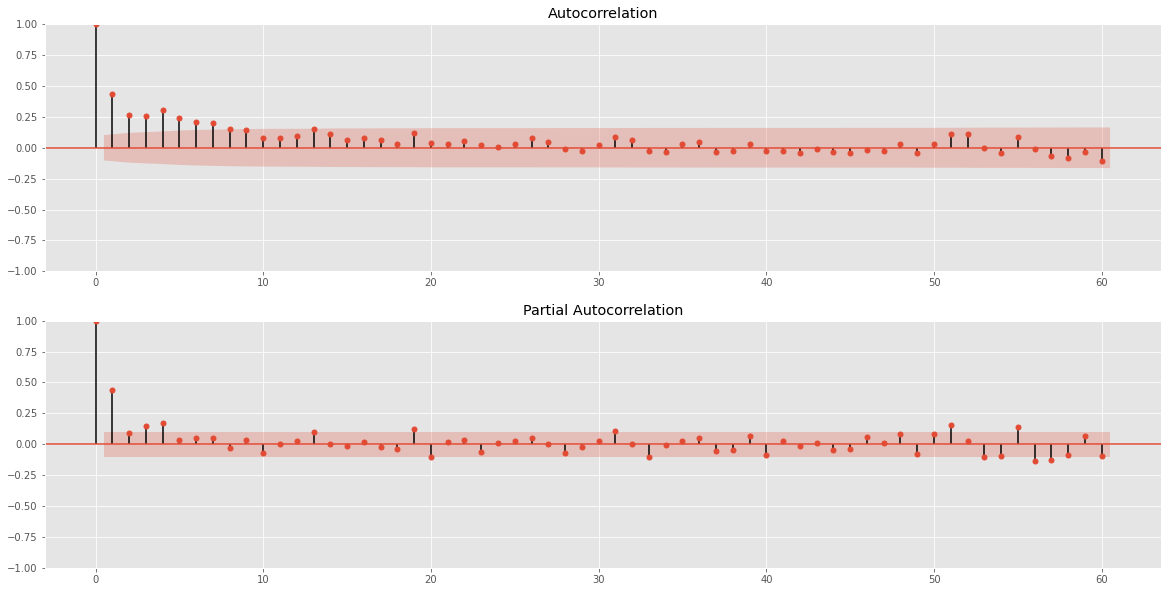

In [ ]:
# 차분안한것
import statsmodels.api as sum

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seoul, lags=60, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seoul, lags=60, ax=ax2)

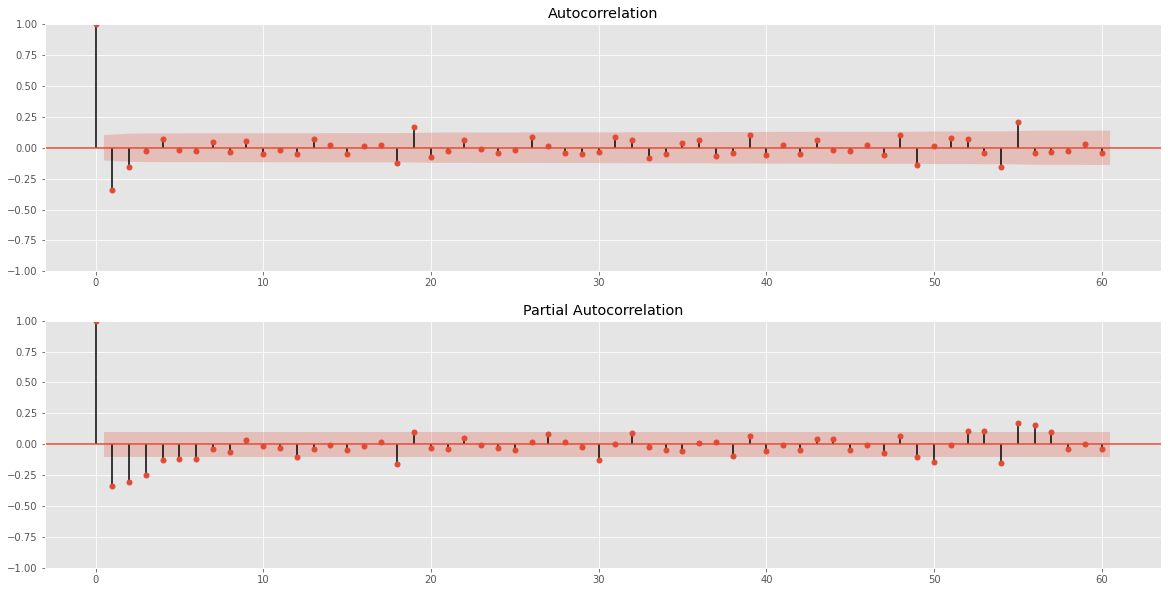

In [ ]:
# 차분한것
# pacf 플롯을 그려 p,q를 결정
import statsmodels.api as sum

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seoul_diff[1:], lags=60, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seoul_diff[1:], lags=60, ax=ax2)
# p=3, d=1 q=5

In [ ]:
# auto_arima로 pdq 최적값 찾기
from pmdarima.arima import auto_arima

model_arima= auto_arima(seoul_diff,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,d=1,suppress_warnings=True,stepwise=False,seasonal=False)

model_arima.fit(seoul)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5877.193, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5737.830, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5664.405, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5591.886, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 7.

ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

# fit model
model = ARIMA(seoul_diff, order=(3,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  seoul   No. Observations:                  365
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2713.478
Date:                Thu, 18 Nov 2021   AIC                           5436.956
Time:                        05:39:20   BIC                           5456.456
Sample:                    01-12-2014   HQIC                          5444.706
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7453     10.330     -0.072      0.942     -20.992      19.502
ar.L1         -0.5294      0.034    -15.798      0.000      -0.595      -0.464
ar.L2         -0.4312      0.052     -8.353      0.0

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(seoul_diff, test_size=0.2, shuffle=False)

In [ ]:
train_reset = train.reset_index()
test_reset = test.reset_index()

In [ ]:
# auto_arima로 pdq 최적값 찾기
from pmdarima.arima import auto_arima

model_arima= auto_arima(seoul,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)

model_arima.fit(train)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6666.865, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6283.600, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6056.673, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5943.574, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5551.102, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5448.605, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5438.035, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5440.026, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5511.879, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5439.013, Time=0.69 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5440.054, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5441.502, Time=0.53 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5439.868, Time=0.47 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5441.865, Time=0.48 sec

Best model:  A

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

# fit model
model1 = ARIMA(seoul, order=(1,0,2)).fit() # original
model2 = ARIMA(seoul_diff, order=(0,0,2)).fit() # train diff

# AR coefficients are same
print(model1.polynomial_ar.round(3) == model2.polynomial_ar.round(3))

# MA coefficients are same
print(model1.polynomial_ma.round(3) == model2.polynomial_ma.round(3))

[ True False]
[ True False False]


In [ ]:
forecast = model_fit.forecast(80)
forecast

2019-08-18   -28.317649
2019-08-25   -18.775172
2019-09-01    -1.504459
2019-09-08    -1.504459
2019-09-15    -1.504459
                ...    
2021-01-24    -1.504459
2021-01-31    -1.504459
2021-02-07    -1.504459
2021-02-14    -1.504459
2021-02-21    -1.504459
Freq: W-SUN, Name: predicted_mean, Length: 80, dtype: float64

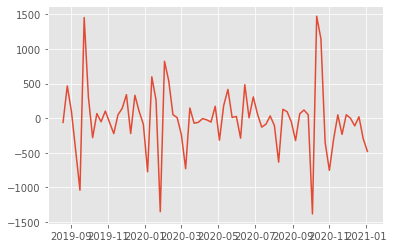

In [ ]:
# plt.plot(test)
# plt.plot(forecast)

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)